## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Import Statements

In [1]:
from skimage.feature import hog

In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [3]:
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [5]:
from PIL import Image

### Load Training Data

In [6]:
#car_images = glob.glob('dataset/vehicles/Combined/*.jpg')
#for images in car_images:
#    print (images)
#    im = Image.open(images)
#    im2 = im.resize((64,  64), Image.BICUBIC)
#    im2.save(images.replace("jpg", "png"))


In [7]:
car_images = glob.glob('dataset/vehicles/Combined/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

1998 8969


### Visualize Some of the Data

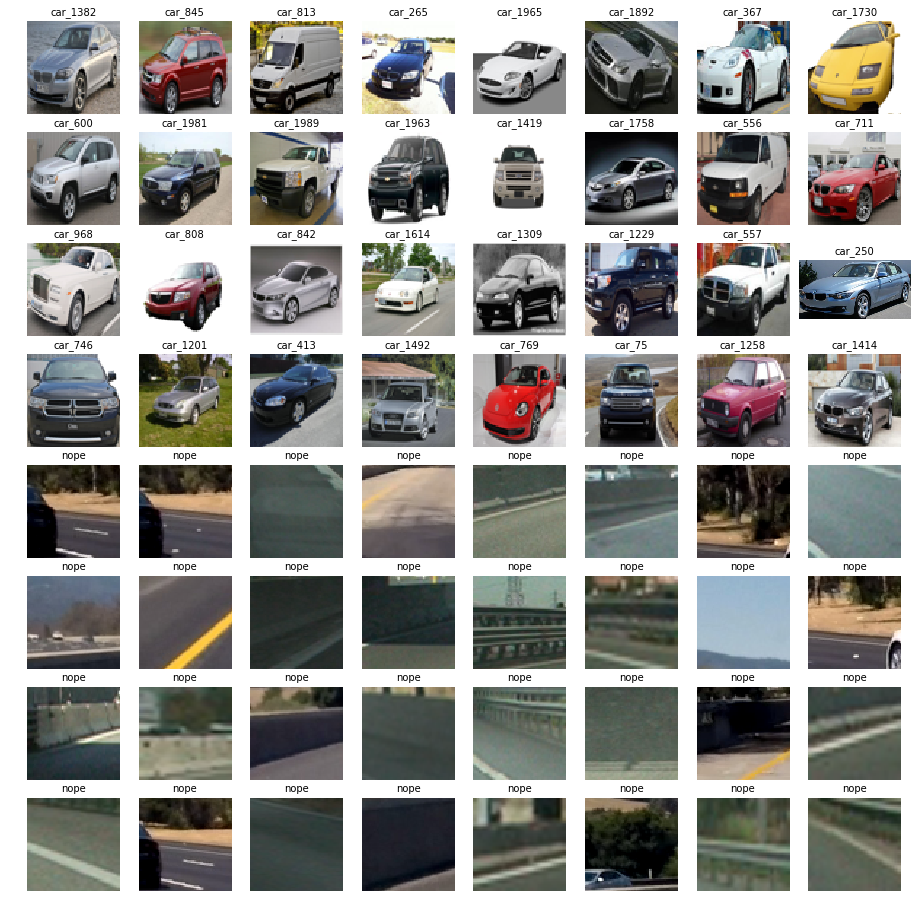

In [8]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    idx = np.random.randint(0,len(car_images))
    img = cv2.imread(car_images[idx])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car_{}'.format(idx), fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

### Define Method to Convert Image to Histogram of Oriented Gradients (HOG)

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features


Visualize HOG on example image

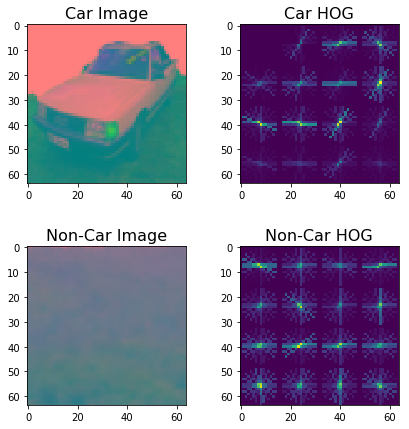

In [10]:
car_img = mpimg.imread(car_images[5])
orientations=11
pixels_per_cell=16
cells_per_block=2
feature_car_image = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV) # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb

# feature_car_image[:,:,2]
_, car_dst = get_hog_features(feature_car_image[:,:,0], orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
feature_noncar_image = cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YUV) 

_, noncar_dst = get_hog_features(feature_noncar_image[:,:,1], orientations, pixels_per_cell, cells_per_block, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)

ax1.imshow(feature_car_image, cmap='gray')
ax1.set_title('Car Image', fontsize=16)

ax2.imshow(car_dst)
ax2.set_title('Car HOG', fontsize=16)

ax3.imshow(feature_noncar_image, cmap='gray')
ax3.set_title('Non-Car Image', fontsize=16)

ax4.imshow(noncar_dst)
ax4.set_title('Non-Car HOG', fontsize=16)


### Method to Extract HOG Features from an Array of Car and Non-Car Images
*The code for this method was mostly duplicated from course lesson material.*

In [11]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    ignore_images = 0
    accept_images = 0
    # Iterate through the list of images
    for file in imgs:
        #print("Processing file:", file)
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)         
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if (len(feature_image.shape) > 2):
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        else:
            hog_features = get_hog_features(feature_image, orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append the new feature vector to the features list
        if(hog_features.shape[0] != 1188):
            print("Ignoring ", file, hog_features.shape[0])
            ignore_images +=1
        else:
            features.append(hog_features)
            accept_images +=1
            
    print("Total Images ignored: ", ignore_images, hog_features.shape[0])
    print("Total Images accepted: ", accept_images, hog_features.shape[0])

    for f in features:
        if (f.shape[0] != 1188):
            print('Found issue')
    
    # Return list of feature vectors
    return features

### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [12]:
# Feature extraction parameters
colorspace = 'RGB' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = orientations
pix_per_cell = pixels_per_cell
cell_per_block = cells_per_block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
for c,n in zip(car_features, notcar_features):
    X = np.vstack((c,n))
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Ignoring  dataset/vehicles/Combined/39.png 337392
Ignoring  dataset/vehicles/Combined/5.png 51744
Ignoring  dataset/vehicles/Combined/17.png 4224
Ignoring  dataset/vehicles/Combined/37.png 120120
Ignoring  dataset/vehicles/Combined/42.png 221760
Ignoring  dataset/vehicles/Combined/03469.png 396
Ignoring  dataset/vehicles/Combined/41.png 74052
Ignoring  dataset/vehicles/Combined/35.png 11088
Ignoring  dataset/vehicles/Combined/6.png 51744
Ignoring  dataset/vehicles/Combined/8.png 62832
Ignoring  dataset/vehicles/Combined/1.png 51744
Ignoring  dataset/vehicles/Combined/12.png 12936
Ignoring  dataset/vehicles/Combined/47.png 54912
Ignoring  dataset/vehicles/Combined/19.png 80784
Ignoring  dataset/vehicles/Combined/67.png 11088
Ignoring  dataset/vehicles/Combined/33.png 1492920
Ignoring  dataset/vehicles/Combined/63.png 92400
Ignoring  dataset/vehicles/Combined/22.png 11880
Ignoring  dataset/vehicles/Combined/3.png 51744
Ignoring  dataset/vehicles/Combined/38.png 744480
Ignoring  dataset/v

**Parameter exploration**

| Configuration Label | Colorspace | Orientations | Pixels Per Cell | Cells Per Block | HOG Channel | Extract Time |
| :-----------------: | :--------: | :----------: | :-------------: | :-------------: | :---------: | ------------:|
| 1                   | RGB        | 9            | 8               | 2               | ALL         | 71.16        |
| 2                   | HSV        | 9            | 8               | 2               | 1           | 43.74        |
| 3                   | HSV        | 9            | 8               | 2               | 2           | 36.35        |
| 4                   | LUV        | 9            | 8               | 2               | 0           | 37.42        |
| 5                   | LUV        | 9            | 8               | 2               | 1           | 38.34        |
| 6                   | HLS        | 9            | 8               | 2               | 0           | 37.42        |
| 7                   | HLS        | 9            | 8               | 2               | 1           | 42.04        |
| 8                   | YUV        | 9            | 8               | 2               | 0           | 35.86        |
| 9                   | YCrCb      | 9            | 8               | 2               | 1           | 38.32        |
| 10                  | YCrCb      | 9            | 8               | 2               | 2           | 38.99        |
| 11                  | HSV        | 9            | 8               | 2               | ALL         | 79.72        |
| 12                  | LUV        | 9            | 8               | 2               | ALL         | 78.57        |
| 13                  | HLS        | 9            | 8               | 2               | ALL         | 81.37        |
| 14                  | YUV        | 9            | 8               | 2               | ALL         | 81.82        |
| 15                  | YCrCb      | 9            | 8               | 2               | ALL         | 79.05        |
| 16                  | YUV        | 9            | 8               | 1               | 0           | 44.04        |
| 17                  | YUV        | 9            | 8               | 3               | 0           | 37.74        |
| 18                  | YUV        | 6            | 8               | 2               | 0           | 37.12        |
| 19                  | YUV        | 12           | 8               | 2               | 0           | 40.11        |
| 20                  | YUV        | 11           | 8               | 2               | 0           | 38.01        |
| 21                  | YUV        | 11           | 16              | 2               | 0           | 30.21        |
| 22                  | YUV        | 11           | 12              | 2               | 0           | 30.33        |
| 23                  | YUV        | 11           | 4               | 2               | 0           | 69.08        |
| 24                  | YUV        | 11           | 16              | 2               | ALL         | 55.20        |
| 25                  | YUV        | 7            | 16              | 2               | ALL         | 53.18        |


### Train a Classifier

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras import utils

Using TensorFlow backend.


In [14]:
no_of_features = 1188
y_train_oh = utils.to_categorical(y_train, num_classes=2)
y_test_oh = utils.to_categorical(y_test, num_classes=2)

In [15]:
print("Training Data shape", X_train.shape, "; Output label shape", y_train_oh.shape)

Training Data shape (5448, 1188) ; Output label shape (5448, 2)


In [16]:
print("Testing Data shape", X_test.shape, "; Output label shape", y_test_oh.shape)

Testing Data shape (5448, 1188) ; Output label shape (5448, 2)


In [17]:
# Use a FCN 

model = Sequential()
# Dense(1188) is a fully-connected layer with 64 hidden units.

model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
#model.add(Dropout(0.5))
model.add(Dense(int(X_train.shape[1]), activation='relu'))
model.add(Dense(int(X_train.shape[1] * 0.5), activation='relu'))


#model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

opt = Adam(lr=0.00001) #lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Check the training time

t = time.time()
model.fit(X_train, y_train_oh,epochs=10, batch_size=100, validation_split=0.2)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train FCN...')


Train on 4358 samples, validate on 1090 samples
Epoch 1/10
4358/4358 [==============================] - 3s - loss: 0.2841 - acc: 0.8752 - val_loss: 0.1381 - val_acc: 0.9385
Epoch 2/10
4358/4358 [==============================] - 2s - loss: 0.1035 - acc: 0.9656 - val_loss: 0.0883 - val_acc: 0.9679
Epoch 3/10
4358/4358 [==============================] - 2s - loss: 0.0699 - acc: 0.9805 - val_loss: 0.0660 - val_acc: 0.9817
Epoch 4/10
4358/4358 [==============================] - 2s - loss: 0.0519 - acc: 0.9881 - val_loss: 0.0526 - val_acc: 0.9826
Epoch 5/10
4358/4358 [==============================] - 2s - loss: 0.0403 - acc: 0.9922 - val_loss: 0.0430 - val_acc: 0.9899
Epoch 6/10
4358/4358 [==============================] - 2s - loss: 0.0324 - acc: 0.9940 - val_loss: 0.0353 - val_acc: 0.9927
Epoch 7/10
4358/4358 [==============================] - 2s - loss: 0.0271 - acc: 0.9943 - val_loss: 0.0307 - val_acc: 0.9936
Epoch 8/10
4358/4358 [==============================] - 2s - loss: 0.0220 - a

In [18]:
# Check the score of the SVC
score = model.evaluate(X_test, y_test_oh, batch_size=128)
print('Test Accuracy of SVC = ', score)

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Example FCN predicts: ', np.argmax(model.predict(X_test[0:n_predict]), axis = 1))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with FCN')

5120/5448 [===========================>..] - ETA: 0sTest Accuracy of SVC =  [0.028681565136286304, 0.99155653433302604]
Example FCN predicts:  [0 1 0 0 0 0 0 0 0 0]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
0.01582 Seconds to predict 10 labels with FCN


### Method for Using Classifier to Detect Cars in an Image

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'GRAY':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    else: ctrans_tosearch = np.copy(img_tosearch)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    elif hog_channel == 'GRAY':
        ch1 = ctrans_tosearch
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64

    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(5, nxsteps-10):
       
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            hog_features = hog_features.reshape(-1, no_of_features)
            test_prediction = np.argmax(svc.predict(hog_features), axis = 1)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    

### Method to Draw Rectangles onto an Image

In [20]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, `find_cars` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  19


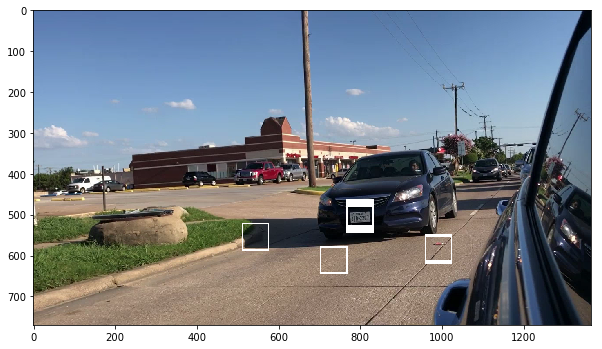

In [21]:
test_img = mpimg.imread('./test_images/BlindSpotHD1.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  106


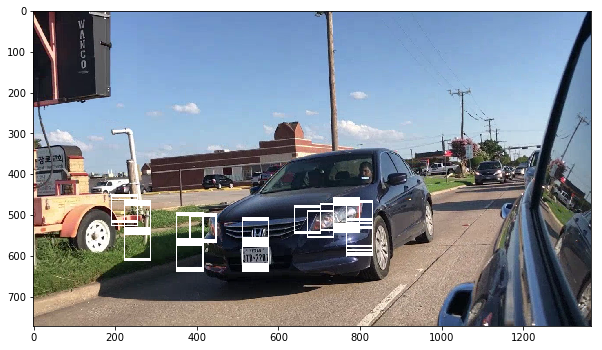

In [22]:
test_img = mpimg.imread('./test_images/BlindSpotHD2.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  127


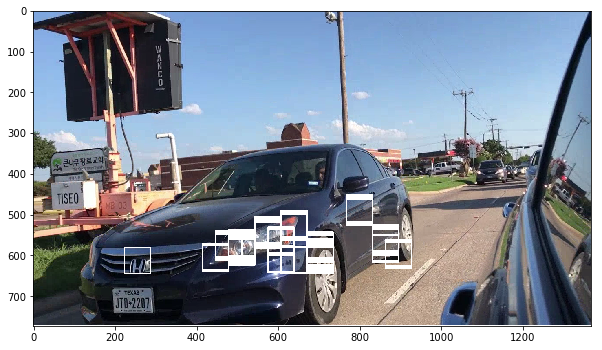

In [23]:
test_img = mpimg.imread('./test_images/BlindSpotHD3.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  48


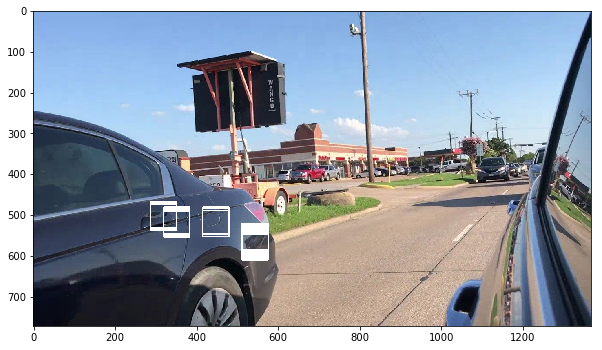

In [24]:
test_img = mpimg.imread('./test_images/BlindSpotHD4.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  16


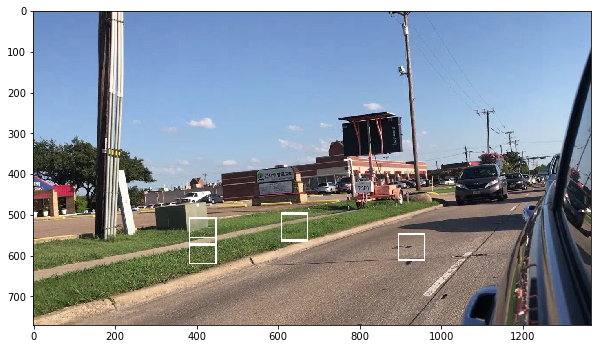

In [25]:
test_img = mpimg.imread('./test_images/BlindSpotHD5.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  42


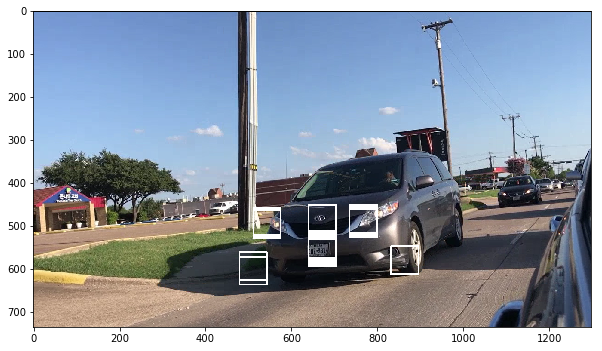

In [26]:
test_img = mpimg.imread('./test_images/BlindSpotHD6.png')

rects = []

ystart = 450
ystop = 550
scale = 1

for i in range(0,100,2):
    #ystart += i
    #ystop += i
    rects.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches

*Exploration findings:* 
- A scale of less than 1.0 seemed to produce a lot of false positives. 
- The start and stop positions and scales used may need some tweaking in the future, depending on video performance.

### Heatmap
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

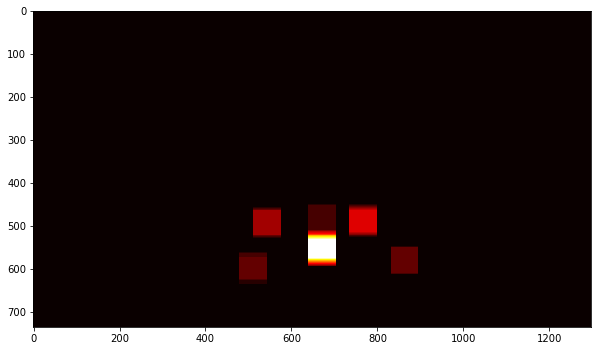

In [28]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply a Threshold to the Heatmap

In [29]:
threshold = 10
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [30]:
heatmap_img.max()

22.0

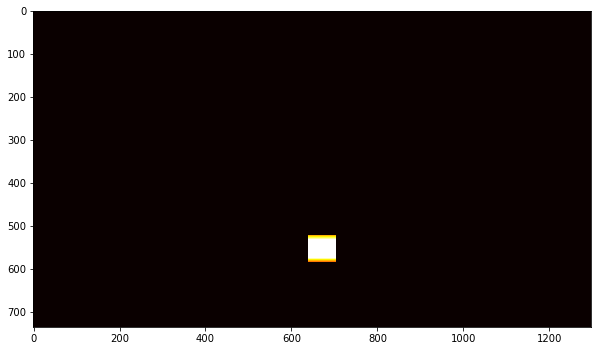

In [31]:
heatmap_img = apply_threshold(heatmap_img.copy(), threshold)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply SciPy Labels to Heatmap

1 cars found


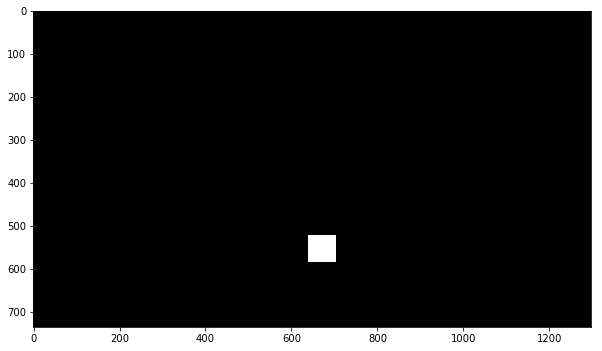

In [32]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

Area:  3969


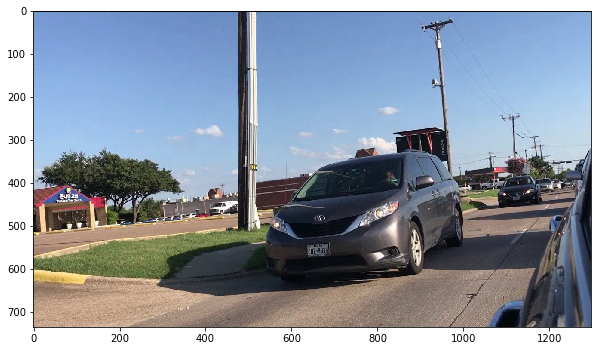

In [33]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        height = bbox[1][1] - bbox[0][1]
        lenght = bbox[1][0] - bbox[0][0]
        area = lenght * height 
        # Draw the box on the image
        print ("Area: ", area)
        if("areas" in locals()):
            areas.append(area)
        if (area > 15000):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Put it All Together

In [34]:
def process_frame(img):

    rectangles = []
    global colorspace
    #colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = orientations
    pix_per_cell = pixels_per_cell
    cell_per_block = cells_per_block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 450
    ystop = 550
    scale = 1.0

    for i in range(0,100,2):
        #ystart += i
        #ystop += i
        rectangles.append(find_cars(test_img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=False))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, threshold)
    
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

Run the pipeline on all the test images.

Area:  3969
Area:  3969
Area:  3969
Area:  3969
Area:  3969
Area:  3969
Area:  3969
Area:  3969


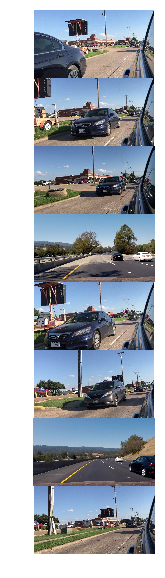

In [35]:
test_images = glob.glob('./test_images/*.*')

fig, axs = plt.subplots(8,1, figsize=(10,10))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


### Run a Video Through the Pipeline (primitive version)
This only processes a frame at a time without accounting for information from previous frames

### Define a Class to Store Data from Vehicle Detections

In [36]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 10:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-10:]

### Pipeline for Processing Video Frames

In [37]:
threshold += 5
def process_frame_for_video(img):

    rectangles = []
    global colorspace
    
    #colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = orientations
    pix_per_cell = pixels_per_cell
    cell_per_block = cells_per_block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 450
    ystop = 550
    scale = 1.5

    for i in range(0,100,2):
        #ystart += i
        #ystop += i
        rectangles.append(find_cars(img, ystart+i, ystop+i, scale, colorspace, hog_channel, model, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, threshold + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


### Run a Video Through the Pipeline (advanced version)
This processes each frame while accounting for information from previous frames

In [38]:
det = Vehicle_Detect()

test_out_file2 = '1_out.mp4'
clip_test2 = VideoFileClip('1.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video 1_out.mp4
[MoviePy] Writing video 1_out.mp4


  2%|▏         | 8/386 [00:32<25:37,  4.07s/it]

Area:  6175


  2%|▏         | 9/386 [00:36<25:29,  4.06s/it]

Area:  6555


  3%|▎         | 10/386 [00:40<25:28,  4.06s/it]

Area:  7315


  3%|▎         | 11/386 [00:44<25:23,  4.06s/it]

Area:  3431


  3%|▎         | 12/386 [00:48<25:12,  4.04s/it]

Area:  3431


  3%|▎         | 13/386 [00:52<25:00,  4.02s/it]

Area:  3431


  4%|▎         | 14/386 [00:56<25:04,  4.05s/it]

Area:  3525


  4%|▍         | 15/386 [01:00<24:51,  4.02s/it]

Area:  3525


  4%|▍         | 16/386 [01:04<24:45,  4.01s/it]

Area:  3525


  4%|▍         | 17/386 [01:08<24:34,  4.00s/it]

Area:  11297


  5%|▍         | 18/386 [01:12<24:35,  4.01s/it]

Area:  21879


  5%|▍         | 19/386 [01:16<24:30,  4.01s/it]

Area:  36567


  5%|▌         | 20/386 [01:20<24:29,  4.02s/it]

Area:  22729


  5%|▌         | 21/386 [01:24<24:23,  4.01s/it]

Area:  24639


  6%|▌         | 22/386 [01:28<24:20,  4.01s/it]

Area:  32743


  6%|▌         | 23/386 [01:32<24:18,  4.02s/it]

Area:  28459


  6%|▌         | 24/386 [01:36<24:17,  4.03s/it]

Area:  38001


  6%|▋         | 25/386 [01:40<24:18,  4.04s/it]

Area:  39435


  7%|▋         | 26/386 [01:44<24:22,  4.06s/it]

Area:  31515


  7%|▋         | 27/386 [01:49<24:20,  4.07s/it]

Area:  31897


  7%|▋         | 28/386 [01:53<24:19,  4.08s/it]

Area:  33043


  8%|▊         | 29/386 [01:57<24:13,  4.07s/it]

Area:  33043


  8%|▊         | 30/386 [02:01<24:14,  4.09s/it]

Area:  33043


  8%|▊         | 31/386 [02:05<24:10,  4.09s/it]

Area:  33043


  8%|▊         | 32/386 [02:09<24:04,  4.08s/it]

Area:  33043


  9%|▊         | 33/386 [02:13<24:03,  4.09s/it]

Area:  21593


  9%|▉         | 34/386 [02:17<24:05,  4.11s/it]

Area:  24453


  9%|▉         | 35/386 [02:21<24:01,  4.11s/it]

Area:  24453


  9%|▉         | 36/386 [02:25<23:58,  4.11s/it]

Area:  17589


 10%|▉         | 37/386 [02:30<23:57,  4.12s/it]

Area:  11305


 10%|▉         | 38/386 [02:34<23:59,  4.14s/it]

Area:  11495


 10%|█         | 39/386 [02:38<23:48,  4.12s/it]

Area:  17303


 10%|█         | 40/386 [02:42<23:43,  4.11s/it]

Area:  17303


 11%|█         | 41/386 [02:46<23:40,  4.12s/it]

Area:  18161


 11%|█         | 42/386 [02:50<23:38,  4.12s/it]

Area:  19591
Area:  2585


 11%|█         | 43/386 [02:54<23:37,  4.13s/it]

Area:  19305
Area:  8455


 11%|█▏        | 44/386 [02:59<23:36,  4.14s/it]

Area:  19305
Area:  15015


 12%|█▏        | 45/386 [03:03<23:35,  4.15s/it]

Area:  26549
Area:  16159


 12%|█▏        | 46/386 [03:07<23:31,  4.15s/it]

Area:  27695
Area:  23111


 12%|█▏        | 47/386 [03:11<23:29,  4.16s/it]

Area:  27695
Area:  23875


 12%|█▏        | 48/386 [03:15<23:25,  4.16s/it]

Area:  21021
Area:  24257


 13%|█▎        | 49/386 [03:19<23:18,  4.15s/it]

Area:  20735
Area:  24639


 13%|█▎        | 50/386 [03:23<23:13,  4.15s/it]

Area:  20163
Area:  32265


 13%|█▎        | 51/386 [03:28<23:07,  4.14s/it]

Area:  18733
Area:  39893


 13%|█▎        | 52/386 [03:32<23:02,  4.14s/it]

Area:  12065
Area:  34177


 14%|█▎        | 53/386 [03:36<22:59,  4.14s/it]

Area:  36089
Area:  12065


 14%|█▍        | 54/386 [03:40<23:08,  4.18s/it]

Area:  43337
Area:  12065


 14%|█▍        | 55/386 [03:44<23:13,  4.21s/it]

Area:  35611
Area:  11495


 15%|█▍        | 56/386 [03:49<23:05,  4.20s/it]

Area:  37045
Area:  10735


 15%|█▍        | 57/386 [03:53<22:58,  4.19s/it]

Area:  60897


 15%|█▌        | 58/386 [03:57<22:50,  4.18s/it]

Area:  39435


 15%|█▌        | 59/386 [04:01<22:34,  4.14s/it]

Area:  39435


 16%|█▌        | 60/386 [04:05<22:20,  4.11s/it]

Area:  39435


 16%|█▌        | 61/386 [04:09<22:10,  4.09s/it]

Area:  31897


 16%|█▌        | 62/386 [04:13<22:05,  4.09s/it]

Area:  31897


 16%|█▋        | 63/386 [04:17<21:58,  4.08s/it]

Area:  31897


 17%|█▋        | 64/386 [04:21<21:57,  4.09s/it]

Area:  31897


 17%|█▋        | 65/386 [04:25<21:49,  4.08s/it]

Area:  31897


 17%|█▋        | 66/386 [04:30<21:45,  4.08s/it]

Area:  31897


 17%|█▋        | 67/386 [04:34<21:36,  4.06s/it]

Area:  31897


 18%|█▊        | 68/386 [04:38<21:30,  4.06s/it]

Area:  23309


 18%|█▊        | 69/386 [04:42<21:31,  4.07s/it]

Area:  23309


 18%|█▊        | 70/386 [04:46<21:29,  4.08s/it]

Area:  23309


 18%|█▊        | 71/386 [04:50<21:26,  4.08s/it]

Area:  23309


 19%|█▊        | 72/386 [04:54<21:32,  4.12s/it]

Area:  23309
Area:  8455


 19%|█▉        | 73/386 [04:58<21:22,  4.10s/it]

Area:  21879
Area:  9595


 19%|█▉        | 74/386 [05:02<21:17,  4.09s/it]

Area:  12445
Area:  10165


 19%|█▉        | 75/386 [05:06<21:11,  4.09s/it]

Area:  3619
Area:  10545


 20%|█▉        | 76/386 [05:10<21:02,  4.07s/it]

Area:  16445


 20%|█▉        | 77/386 [05:14<20:53,  4.06s/it]

Area:  16731


 20%|██        | 78/386 [05:18<20:50,  4.06s/it]

Area:  17303


 20%|██        | 79/386 [05:22<20:48,  4.07s/it]

Area:  24257


 21%|██        | 80/386 [05:27<20:44,  4.07s/it]

Area:  24639


 21%|██        | 81/386 [05:31<20:38,  4.06s/it]

Area:  24257


 21%|██        | 82/386 [05:35<20:30,  4.05s/it]

Area:  23875


 22%|██▏       | 83/386 [05:39<20:22,  4.04s/it]

Area:  29397


 22%|██▏       | 84/386 [05:43<20:27,  4.06s/it]

Area:  23111


 22%|██▏       | 85/386 [05:47<20:23,  4.06s/it]

Area:  22347


 22%|██▏       | 86/386 [05:51<20:20,  4.07s/it]

Area:  21965


 23%|██▎       | 87/386 [05:55<20:18,  4.08s/it]

Area:  21965


 23%|██▎       | 88/386 [05:59<20:10,  4.06s/it]

Area:  16159


 23%|██▎       | 89/386 [06:03<20:07,  4.07s/it]

Area:  21583


 23%|██▎       | 90/386 [06:07<20:03,  4.07s/it]

Area:  21583


 24%|██▎       | 91/386 [06:11<19:53,  4.05s/it]

Area:  21201


 24%|██▍       | 92/386 [06:15<19:47,  4.04s/it]

Area:  15873


 24%|██▍       | 93/386 [06:19<19:45,  4.05s/it]

Area:  15873


 24%|██▍       | 94/386 [06:23<19:44,  4.06s/it]

Area:  15587


 25%|██▍       | 95/386 [06:27<19:38,  4.05s/it]

Area:  15301


 25%|██▍       | 96/386 [06:31<19:31,  4.04s/it]

Area:  20437


 25%|██▌       | 97/386 [06:35<19:29,  4.05s/it]

Area:  15301


 25%|██▌       | 98/386 [06:39<19:24,  4.04s/it]

Area:  15015


 26%|██▌       | 99/386 [06:44<19:21,  4.05s/it]

Area:  14443


 26%|██▌       | 100/386 [06:48<19:17,  4.05s/it]

Area:  14443


 26%|██▌       | 101/386 [06:52<19:13,  4.05s/it]

Area:  9215


 26%|██▋       | 102/386 [06:56<19:09,  4.05s/it]

Area:  9025


 27%|██▋       | 103/386 [07:00<19:04,  4.04s/it]

Area:  9025


 27%|██▋       | 104/386 [07:04<18:59,  4.04s/it]

Area:  9025


 27%|██▋       | 105/386 [07:08<18:54,  4.04s/it]

Area:  9025


 27%|██▋       | 106/386 [07:12<18:51,  4.04s/it]

Area:  9025


 28%|██▊       | 107/386 [07:16<18:44,  4.03s/it]

Area:  9025


 28%|██▊       | 108/386 [07:20<18:42,  4.04s/it]

Area:  8835


 28%|██▊       | 109/386 [07:24<18:41,  4.05s/it]

Area:  8075
Area:  3337


 28%|██▊       | 110/386 [07:28<18:37,  4.05s/it]

Area:  8075
Area:  3337


 29%|██▉       | 111/386 [07:32<18:27,  4.03s/it]

Area:  8075
Area:  3337


 29%|██▉       | 112/386 [07:36<18:23,  4.03s/it]

Area:  8075
Area:  3337


 29%|██▉       | 113/386 [07:40<18:19,  4.03s/it]

Area:  8075
Area:  3337


 30%|██▉       | 114/386 [07:44<18:17,  4.03s/it]

Area:  8075
Area:  3337


 30%|██▉       | 115/386 [07:48<18:12,  4.03s/it]

Area:  8075
Area:  3337


 30%|███       | 116/386 [07:52<18:09,  4.03s/it]

Area:  8075
Area:  3337


 30%|███       | 117/386 [07:56<18:01,  4.02s/it]

Area:  8075
Area:  3337


 31%|███       | 118/386 [08:00<17:55,  4.01s/it]

Area:  8075
Area:  3337


 31%|███       | 119/386 [08:04<17:42,  3.98s/it]

Area:  8075
Area:  3337


 31%|███       | 120/386 [08:08<17:37,  3.97s/it]

Area:  8075
Area:  3337


 31%|███▏      | 121/386 [08:12<17:30,  3.96s/it]

Area:  8075
Area:  3337


 32%|███▏      | 122/386 [08:16<17:28,  3.97s/it]

Area:  8075
Area:  3337


 32%|███▏      | 123/386 [08:20<17:26,  3.98s/it]

Area:  3337


 32%|███▏      | 124/386 [08:24<17:23,  3.98s/it]

Area:  3337


 32%|███▏      | 125/386 [08:28<17:21,  3.99s/it]

Area:  3337


 33%|███▎      | 126/386 [08:32<17:16,  3.99s/it]

Area:  3337


 33%|███▎      | 127/386 [08:36<17:16,  4.00s/it]

Area:  3337


 33%|███▎      | 128/386 [08:40<17:20,  4.03s/it]

Area:  3337


 33%|███▎      | 129/386 [08:44<17:23,  4.06s/it]

Area:  3337


 34%|███▎      | 130/386 [08:48<17:20,  4.06s/it]

Area:  3337


 34%|███▍      | 131/386 [08:52<17:15,  4.06s/it]

Area:  3337


 34%|███▍      | 132/386 [08:56<17:07,  4.05s/it]

Area:  3337


 34%|███▍      | 133/386 [09:00<17:03,  4.04s/it]

Area:  3337


 35%|███▍      | 134/386 [09:04<16:54,  4.03s/it]

Area:  3337


 35%|███▍      | 135/386 [09:08<16:45,  4.01s/it]

Area:  3337


 35%|███▌      | 136/386 [09:12<16:38,  3.99s/it]

Area:  3337


 35%|███▌      | 137/386 [09:16<16:33,  3.99s/it]

Area:  3713


 36%|███▌      | 138/386 [09:20<16:29,  3.99s/it]

Area:  3713


 36%|███▌      | 139/386 [09:24<16:25,  3.99s/it]

Area:  3713


 36%|███▋      | 140/386 [09:28<16:23,  4.00s/it]

Area:  3713


 37%|███▋      | 141/386 [09:32<16:18,  3.99s/it]

Area:  3713


 37%|███▋      | 142/386 [09:36<16:15,  4.00s/it]

Area:  3713


 37%|███▋      | 143/386 [09:40<16:16,  4.02s/it]

Area:  3713


 37%|███▋      | 144/386 [09:44<16:15,  4.03s/it]

Area:  3713


 38%|███▊      | 145/386 [09:48<16:13,  4.04s/it]

Area:  3713


 38%|███▊      | 146/386 [09:52<16:10,  4.04s/it]

Area:  3713


 38%|███▊      | 147/386 [09:56<16:02,  4.03s/it]

Area:  3713


 38%|███▊      | 148/386 [10:00<15:56,  4.02s/it]

Area:  3713


 39%|███▊      | 149/386 [10:04<15:52,  4.02s/it]

Area:  3713


 39%|███▉      | 150/386 [10:09<15:53,  4.04s/it]

Area:  3713


 39%|███▉      | 151/386 [10:13<15:46,  4.03s/it]

Area:  3713


 39%|███▉      | 152/386 [10:17<15:40,  4.02s/it]

Area:  3713


 40%|███▉      | 153/386 [10:21<15:38,  4.03s/it]

Area:  3713


 40%|███▉      | 154/386 [10:25<15:34,  4.03s/it]

Area:  3713


 40%|████      | 155/386 [10:29<15:34,  4.05s/it]

Area:  3713


 40%|████      | 156/386 [10:33<15:29,  4.04s/it]

Area:  3713


 60%|█████▉    | 231/386 [15:31<10:00,  3.87s/it]

Area:  3705


 60%|██████    | 232/386 [15:35<10:00,  3.90s/it]

Area:  3705


 60%|██████    | 233/386 [15:39<09:57,  3.90s/it]

Area:  3705


 61%|██████    | 234/386 [15:43<09:55,  3.92s/it]

Area:  7885


 61%|██████    | 235/386 [15:47<09:47,  3.89s/it]

Area:  8455


 61%|██████    | 236/386 [15:51<09:42,  3.88s/it]

Area:  8455


 61%|██████▏   | 237/386 [15:55<09:41,  3.91s/it]

Area:  8455


 62%|██████▏   | 238/386 [15:58<09:40,  3.92s/it]

Area:  8455


 62%|██████▏   | 239/386 [16:02<09:38,  3.94s/it]

Area:  8455


 62%|██████▏   | 240/386 [16:06<09:34,  3.93s/it]

Area:  8455
Area:  2773


 62%|██████▏   | 241/386 [16:10<09:30,  3.94s/it]

Area:  8455
Area:  2773


 63%|██████▎   | 242/386 [16:14<09:24,  3.92s/it]

Area:  8455
Area:  2773


 63%|██████▎   | 243/386 [16:18<09:18,  3.91s/it]

Area:  8455
Area:  2773


 63%|██████▎   | 244/386 [16:22<09:14,  3.90s/it]

Area:  8455
Area:  2773


 63%|██████▎   | 245/386 [16:26<09:10,  3.90s/it]

Area:  8455
Area:  2773


 64%|██████▎   | 246/386 [16:30<09:07,  3.91s/it]

Area:  8455
Area:  2773


 64%|██████▍   | 247/386 [16:34<09:03,  3.91s/it]

Area:  8645
Area:  2773


 64%|██████▍   | 248/386 [16:38<08:57,  3.89s/it]

Area:  8075
Area:  2773


 65%|██████▍   | 249/386 [16:41<08:53,  3.89s/it]

Area:  8075
Area:  2773


 65%|██████▍   | 250/386 [16:45<08:52,  3.92s/it]

Area:  8075
Area:  2773


 65%|██████▌   | 251/386 [16:49<08:46,  3.90s/it]

Area:  8075
Area:  2773


 65%|██████▌   | 252/386 [16:53<08:43,  3.91s/it]

Area:  8075
Area:  2773


 66%|██████▌   | 253/386 [16:57<08:38,  3.90s/it]

Area:  8075
Area:  2773


 66%|██████▌   | 254/386 [17:01<08:36,  3.92s/it]

Area:  8075
Area:  2773


 66%|██████▌   | 255/386 [17:05<08:29,  3.89s/it]

Area:  8075
Area:  2773


 66%|██████▋   | 256/386 [17:09<08:25,  3.89s/it]

Area:  8075
Area:  2773


 67%|██████▋   | 257/386 [17:13<08:22,  3.90s/it]

Area:  8075
Area:  2773


 67%|██████▋   | 258/386 [17:17<08:19,  3.90s/it]

Area:  3619
Area:  3055


 67%|██████▋   | 259/386 [17:20<08:15,  3.90s/it]

Area:  3431


 67%|██████▋   | 260/386 [17:24<08:09,  3.88s/it]

Area:  3431


 68%|██████▊   | 261/386 [17:28<08:01,  3.85s/it]

Area:  3431


 68%|██████▊   | 262/386 [17:32<07:56,  3.85s/it]

Area:  3431


 68%|██████▊   | 263/386 [17:36<07:50,  3.83s/it]

Area:  3431


 68%|██████▊   | 264/386 [17:40<07:48,  3.84s/it]

Area:  3431


 69%|██████▊   | 265/386 [17:43<07:43,  3.83s/it]

Area:  3431


 69%|██████▉   | 266/386 [17:47<07:41,  3.85s/it]

Area:  3431


 69%|██████▉   | 267/386 [17:51<07:38,  3.85s/it]

Area:  3431


 69%|██████▉   | 268/386 [17:55<07:39,  3.89s/it]

Area:  3431


 70%|██████▉   | 269/386 [17:59<07:36,  3.90s/it]

Area:  3055


 70%|██████▉   | 270/386 [18:03<07:34,  3.91s/it]

Area:  3149


 70%|███████   | 271/386 [18:07<07:24,  3.87s/it]

Area:  3149


 70%|███████   | 272/386 [18:11<07:21,  3.87s/it]

Area:  3149


 71%|███████   | 273/386 [18:14<07:11,  3.82s/it]

Area:  2961


 71%|███████   | 274/386 [18:18<07:06,  3.81s/it]

Area:  2961


 71%|███████   | 275/386 [18:22<07:00,  3.79s/it]

Area:  2961


 72%|███████▏  | 276/386 [18:26<06:56,  3.78s/it]

Area:  2961


 72%|███████▏  | 277/386 [18:29<06:52,  3.78s/it]

Area:  2961


 72%|███████▏  | 278/386 [18:33<06:49,  3.79s/it]

Area:  2961


 72%|███████▏  | 279/386 [18:37<06:49,  3.83s/it]

Area:  2961


 73%|███████▎  | 280/386 [18:41<06:51,  3.88s/it]

Area:  2961


 73%|███████▎  | 281/386 [18:45<06:52,  3.93s/it]

Area:  2961


 73%|███████▎  | 282/386 [18:49<06:44,  3.89s/it]

Area:  2961


 79%|███████▉  | 304/386 [20:10<04:57,  3.63s/it]

Area:  8075


 79%|███████▉  | 305/386 [20:14<04:53,  3.63s/it]

Area:  8075


 79%|███████▉  | 306/386 [20:18<04:50,  3.63s/it]

Area:  8075


 80%|███████▉  | 307/386 [20:21<04:47,  3.64s/it]

Area:  9595


 80%|███████▉  | 308/386 [20:25<04:43,  3.64s/it]

Area:  13775


 80%|████████  | 309/386 [20:29<04:42,  3.66s/it]

Area:  13775


 80%|████████  | 310/386 [20:32<04:39,  3.67s/it]

Area:  27695


 81%|████████  | 311/386 [20:36<04:35,  3.67s/it]

Area:  27695


 81%|████████  | 312/386 [20:40<04:32,  3.69s/it]

Area:  35611


 81%|████████  | 313/386 [20:43<04:28,  3.68s/it]

Area:  43337


 81%|████████▏ | 314/386 [20:47<04:27,  3.71s/it]

Area:  45633


 82%|████████▏ | 315/386 [20:51<04:24,  3.73s/it]

Area:  53265


 82%|████████▏ | 316/386 [20:55<04:25,  3.80s/it]

Area:  53935


 82%|████████▏ | 317/386 [20:59<04:27,  3.87s/it]

Area:  35133


 82%|████████▏ | 318/386 [21:03<04:27,  3.94s/it]

Area:  35133


 83%|████████▎ | 319/386 [21:07<04:25,  3.96s/it]

Area:  33221


 83%|████████▎ | 320/386 [21:11<04:22,  3.98s/it]

Area:  24639


 83%|████████▎ | 321/386 [21:15<04:19,  3.99s/it]

Area:  23875


 83%|████████▎ | 322/386 [21:19<04:16,  4.01s/it]

Area:  23875


 84%|████████▎ | 323/386 [21:23<04:13,  4.02s/it]

Area:  17017


 84%|████████▍ | 324/386 [21:27<04:09,  4.03s/it]

Area:  21583
Area:  329


 84%|████████▍ | 325/386 [21:31<04:05,  4.02s/it]

Area:  15587
Area:  329


 84%|████████▍ | 326/386 [21:35<04:02,  4.04s/it]

Area:  15015
Area:  329


 85%|████████▍ | 327/386 [21:39<03:59,  4.06s/it]

Area:  13871
Area:  9215


 85%|████████▍ | 328/386 [21:44<03:56,  4.08s/it]

Area:  8455
Area:  9215


 85%|████████▌ | 329/386 [21:48<03:53,  4.10s/it]

Area:  8835
Area:  18733


 85%|████████▌ | 330/386 [21:52<03:50,  4.11s/it]

Area:  38745


 86%|████████▌ | 331/386 [21:56<03:46,  4.11s/it]

Area:  38171


 86%|████████▌ | 332/386 [22:00<03:42,  4.13s/it]

Area:  38171


 86%|████████▋ | 333/386 [22:04<03:38,  4.12s/it]

Area:  39893


 87%|████████▋ | 334/386 [22:08<03:33,  4.11s/it]

Area:  39893


 87%|████████▋ | 335/386 [22:12<03:29,  4.10s/it]

Area:  39893


 87%|████████▋ | 336/386 [22:17<03:25,  4.12s/it]

Area:  34655


 87%|████████▋ | 337/386 [22:21<03:21,  4.12s/it]

Area:  31787


 88%|████████▊ | 338/386 [22:25<03:19,  4.15s/it]

Area:  35301


 88%|████████▊ | 339/386 [22:29<03:13,  4.12s/it]

Area:  35301


 88%|████████▊ | 340/386 [22:33<03:08,  4.09s/it]

Area:  35175


 88%|████████▊ | 341/386 [22:37<03:03,  4.07s/it]

Area:  28413


 89%|████████▊ | 342/386 [22:41<02:59,  4.07s/it]

Area:  25021


 89%|████████▉ | 343/386 [22:45<02:53,  4.03s/it]

Area:  25021


 89%|████████▉ | 344/386 [22:49<02:49,  4.04s/it]

Area:  25021


 89%|████████▉ | 345/386 [22:53<02:46,  4.05s/it]

Area:  22347


 90%|████████▉ | 346/386 [22:57<02:41,  4.05s/it]

Area:  9595
Area:  9405


 90%|████████▉ | 347/386 [23:01<02:37,  4.04s/it]

Area:  16159
Area:  9405


 90%|█████████ | 348/386 [23:05<02:34,  4.06s/it]

Area:  17589
Area:  15301


 90%|█████████ | 349/386 [23:09<02:29,  4.04s/it]

Area:  24639
Area:  17589


 91%|█████████ | 350/386 [23:13<02:26,  4.06s/it]

Area:  25403
Area:  7125


 91%|█████████ | 351/386 [23:18<02:22,  4.06s/it]

Area:  25785


 91%|█████████ | 352/386 [23:22<02:18,  4.06s/it]

Area:  26167


 91%|█████████▏| 353/386 [23:26<02:14,  4.06s/it]

Area:  26167


 92%|█████████▏| 354/386 [23:30<02:09,  4.05s/it]

Area:  26167


 92%|█████████▏| 355/386 [23:34<02:04,  4.01s/it]

Area:  26167


 92%|█████████▏| 356/386 [23:38<02:00,  4.02s/it]

Area:  26167


 92%|█████████▏| 357/386 [23:42<01:57,  4.06s/it]

Area:  26167


 93%|█████████▎| 358/386 [23:46<01:54,  4.10s/it]

Area:  26167


 93%|█████████▎| 359/386 [23:50<01:49,  4.07s/it]

Area:  26167


 93%|█████████▎| 360/386 [23:54<01:46,  4.08s/it]

Area:  26167


 94%|█████████▎| 361/386 [23:58<01:41,  4.05s/it]

Area:  26167


 94%|█████████▍| 362/386 [24:02<01:36,  4.03s/it]

Area:  26167


 94%|█████████▍| 363/386 [24:06<01:31,  3.99s/it]

Area:  26167


 94%|█████████▍| 364/386 [24:10<01:27,  3.98s/it]

Area:  26167


 95%|█████████▍| 365/386 [24:14<01:22,  3.95s/it]

Area:  26167


 95%|█████████▍| 366/386 [24:18<01:18,  3.93s/it]

Area:  26167


 95%|█████████▌| 367/386 [24:22<01:14,  3.94s/it]

Area:  26167


 95%|█████████▌| 368/386 [24:26<01:11,  3.95s/it]

Area:  26167


 96%|█████████▌| 369/386 [24:29<01:06,  3.94s/it]

Area:  26167


 96%|█████████▌| 370/386 [24:34<01:03,  3.96s/it]

Area:  26167


 96%|█████████▌| 371/386 [24:37<00:59,  3.96s/it]

Area:  26167


 96%|█████████▋| 372/386 [24:41<00:55,  3.96s/it]

Area:  26167


 97%|█████████▋| 373/386 [24:45<00:51,  3.96s/it]

Area:  26167


 97%|█████████▋| 374/386 [24:49<00:47,  3.96s/it]

Area:  26167


 97%|█████████▋| 375/386 [24:53<00:43,  3.98s/it]

Area:  25403


 97%|█████████▋| 376/386 [24:57<00:40,  4.01s/it]

Area:  25403


 98%|█████████▊| 377/386 [25:01<00:35,  3.99s/it]

Area:  25403


 98%|█████████▊| 378/386 [25:05<00:31,  3.97s/it]

Area:  25403


 98%|█████████▊| 379/386 [25:09<00:27,  3.94s/it]

Area:  25403


 98%|█████████▊| 380/386 [25:13<00:23,  3.93s/it]

Area:  25403


 99%|█████████▊| 381/386 [25:17<00:19,  3.92s/it]

Area:  25403


 99%|█████████▉| 382/386 [25:21<00:15,  3.94s/it]

Area:  25403


 99%|█████████▉| 383/386 [25:25<00:11,  3.96s/it]

Area:  25403


 99%|█████████▉| 384/386 [25:29<00:07,  3.95s/it]

Area:  25403


100%|█████████▉| 385/386 [25:33<00:03,  3.95s/it]

Area:  25403


100%|██████████| 386/386 [25:37<00:00,  3.94s/it]

Area:  25403


[MoviePy] Done.
[MoviePy] >>>> Video ready: 1_out.mp4 

CPU times: user 26min 22s, sys: 30.2 s, total: 26min 53s
Wall time: 25min 37s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))